# Momentum trading - oanda

https://www.oreilly.com/learning/algorithmic-trading-in-less-than-100-lines-of-python-code

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from oanda_client import client, config
from momentum_trader import MomentumTrader
%matplotlib inline

The data set itself is for the two days December 8 and 9, 2016, and has a granularity of one minute.

In [2]:
data = client.get_history(instrument='EUR_USD',
                         start='2016-12-08',
                         end='2016-12-10',
                         granularity='M1')

The `data` contains the candles that includes the following information:

In [3]:
data['candles'][0]

{'closeAsk': 1.07602,
 'closeBid': 1.07584,
 'complete': True,
 'highAsk': 1.07602,
 'highBid': 1.07584,
 'lowAsk': 1.07585,
 'lowBid': 1.07569,
 'openAsk': 1.07598,
 'openBid': 1.07582,
 'time': '2016-12-08T00:00:00.000000Z',
 'volume': 13}

Load the candles into a dataframe and the time to be the index

In [4]:
df = pd.DataFrame(data['candles']).set_index('time')

Set index to be `DatatimeIndex`

In [5]:
df.index = pd.DatetimeIndex(df.index)

`pd.Series.shift(periods=1, freq=None, axis=0)`

Shift index by desired number of periods with an optional time freq

Create log returns for each minute

In [6]:
df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))  

`df.rolling(window, min_periods=None, freq=None, center=False, win_type=None, on=None, axis=0, closed=None)`

Provides rolling window calculations.

- `window`: `int`, or `offset`

    Size of the moving window. This is the number of observations used for
    calculating the statistic. Each window will be a fixed size.

    If its an offset then this will be the time period of each window. Each
    window will be a variable sized based on the observations included in
    the time-period. This is only valid for datetimelike indexes. This is
    new in 0.19.0

Take the mean log return over the last 15, 30, 60, and 120 minute bars to derive the position in the instrument. For example, the mean log return for the last 15 minute bars gives the average value of the last 15 return observations. If this value is positive, we go/stay long the traded instrument; if it is negative we go/stay short.

In [7]:
cols = []  
for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    df[col] = np.sign(df['returns'].rolling(momentum).mean())
    cols.append(col)

In [8]:
df['position_15'][13:30]

time
2016-12-08 00:13:00    NaN
2016-12-08 00:14:00    NaN
2016-12-08 00:17:00    1.0
2016-12-08 00:18:00    1.0
2016-12-08 00:19:00    1.0
2016-12-08 00:20:00    1.0
2016-12-08 00:21:00    1.0
2016-12-08 00:23:00   -1.0
2016-12-08 00:24:00   -1.0
2016-12-08 00:25:00   -1.0
2016-12-08 00:26:00   -1.0
2016-12-08 00:27:00   -1.0
2016-12-08 00:29:00   -1.0
2016-12-08 00:31:00   -1.0
2016-12-08 00:32:00   -1.0
2016-12-08 00:33:00   -1.0
2016-12-08 00:35:00    1.0
Name: position_15, dtype: float64

To derive the absolute performance of the momentum strategy for the different momentum intervals (in minutes), you need to multiply the positionings derived above (shifted by one day) by the market returns.

In [9]:
strats = ['returns']

for col in cols:
    strat = 'strategy_%s' % col.split('_')[1]
    df[strat] = df[col].shift(1) * df['returns']
    strats.append(strat)

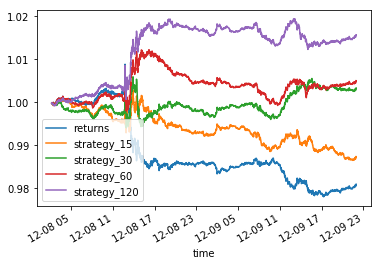

In [10]:
df[strats].dropna().cumsum().apply(np.exp).plot()

In [11]:
mt = MomentumTrader(momentum=12, environment='practice',
                    access_token=config['oanda']['access_token'])

The oanda python api seems to be outdated - the below code doesn't work:

In [12]:
#mt.rates(account_id=config['oanda']['account_id'],
#         instruments=['EUR_USD'], ignore_heartbeat=True)